In [1]:
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_models
import argparse
from PIL import Image
from train import COCOSegmentationDataset, SimultaneousTransform, center_crop_arr
from torchvision import transforms
from matplotlib import pyplot as plt

/home/jqi/anaconda3/envs/DiT/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


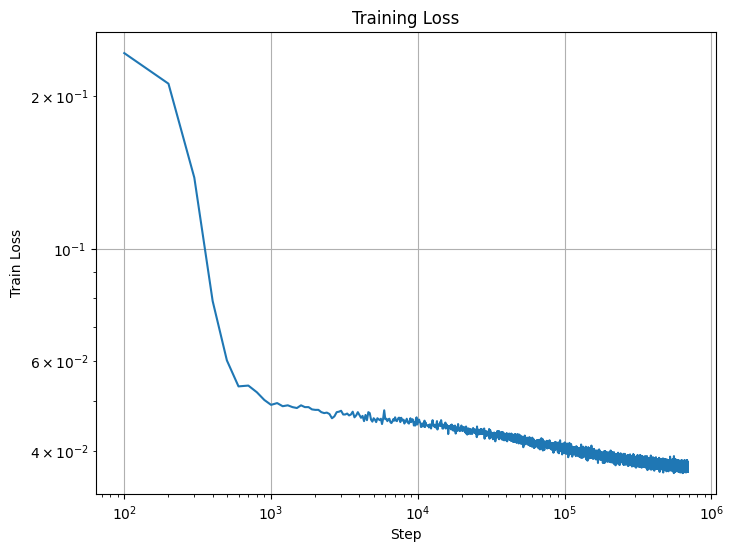

In [2]:
import re
import matplotlib.pyplot as plt

# Read the log file
with open('/home/jqi/Github/DiT/results/005-DiT-S-8/log.txt', 'r') as file:
    log_data = file.read()

# Regular expression pattern to extract step and loss values
pattern = r'\(step=(\d+)\) Train Loss: (\d+\.\d+)'

# Extract step and loss values using the regular expression
matches = re.findall(pattern, log_data)

# Convert matches to lists of integers and floats
steps = [int(match[0]) for match in matches]
losses = [float(match[1]) for match in matches]

# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(steps, losses)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Step')
plt.ylabel('Train Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

In [3]:
# Setup PyTorch:
torch.manual_seed(42)
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# Load model:
latent_size = 256 // 8
model = DiT_models['DiT-S/8'](
    input_size=latent_size,
    num_classes=100
).to(device)


In [5]:
ckpt_path = "/home/jqi/Github/DiT/results/005-DiT-S-8/checkpoints/final.pt"
state_dict = find_model(ckpt_path)
model.load_state_dict(state_dict)
model.eval()  # important!
diffusion = create_diffusion('1000')
vae = AutoencoderKL.from_pretrained(f"stabilityai/sd-vae-ft-ema").to(device)

In [125]:
# transform = transforms.Compose([
#     transforms.Lambda(lambda pil_image: center_crop_arr(pil_image, 256)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True)
# ])
# dataset = COCOSegmentationDataset(root_dir='/home/jqi/Github/Data/Data/coco', split='train2017', transform=SimultaneousTransform(transform))
# loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)



In [6]:
#Load and examine the masks with the origional image
import os
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
import random
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

#customized dataset class for imagenet and mask
class ImageNetandMask(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.samples = []  # A list of tuples (image_path, mask_path, class_index)
        self.class_names = []

        # Assuming same structure for both image_dir and mask_dir
        for class_name in sorted(os.listdir(image_dir)):
            image_class_dir = os.path.join(image_dir, class_name)
            mask_class_dir = os.path.join(mask_dir, class_name)
            if not os.path.isdir(image_class_dir) or not os.path.isdir(mask_class_dir):
                continue
            self.class_names.append(class_name)
            class_index = self.class_names.index(class_name)

            for image_name in os.listdir(image_class_dir):
                if image_name.endswith('.jpeg') or image_name.endswith('.JPEG'):  # Adjust as needed
                    image_path = os.path.join(image_class_dir, image_name)
                    mask_name = os.path.splitext(image_name)[0] + '.npy'  # Change to .npy
                    mask_path = os.path.join(mask_class_dir, mask_name)
                    if os.path.exists(mask_path):  # Check if corresponding mask exists
                        self.samples.append((image_path, mask_path, class_index))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, mask_path, class_index = self.samples[idx]
        
        # Load image and mask
        image = Image.open(image_path).convert("RGB")
        mask = np.load(mask_path)

        # Apply transformations if any
        if self.transform:
            image, mask = self.transform(image, mask)

        return (image, mask), class_index
    
    def get_file_paths(self, idx):
        image_path, mask_path, class_index = self.samples[idx]
        return image_path, mask_path

#customized transform so image and mask could have the same random crop and flip
class RandomResizedCropAndFlip:
    def __init__(self, input_size, scale=(0.2, 1.0)):
        self.input_size = input_size
        self.scale = scale
        self.resized_crop = transforms.RandomResizedCrop(size=input_size, scale=scale, interpolation=3)  # Bicubic
        self.flip = transforms.RandomHorizontalFlip()
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        self.resize = transforms.Resize((input_size, input_size))  # Resize transformation


    def __call__(self, image, mask):
        mask =  Image.fromarray(mask).convert('RGB')

        # Apply the same random crop and flip to both image and mask
        i, j, h, w = self.resized_crop.get_params(image, self.scale, self.resized_crop.ratio)
        image = transforms.functional.crop(image, i, j, h, w)
        mask = transforms.functional.crop(mask, i, j, h, w)

        if random.random() > 0.5:
            image = transforms.functional.hflip(image)
            mask = transforms.functional.hflip(mask)

        # Resize both image and mask
        image = self.resize(image)
        mask = self.resize(mask)

        image = self.to_tensor(image)
        # image = self.normalize(image)
        mask = self.to_tensor(mask)
        # add the mask one more dimension as channel
        # mask = mask.unsqueeze(0)

        return image, mask
    
    

In [7]:
transform_train = RandomResizedCropAndFlip(input_size=256)
dataset_train = ImageNetandMask(os.path.join('/home/jqi/Github/Data/imagenet_100/imagenet100', 'val'), os.path.join('/home/jqi/Github/Data/imagenet_100/imagenet100_masks', 'val'), transform=transform_train)
loader = DataLoader(dataset_train, batch_size=4, shuffle=True)


In [42]:
for i, ((images, masks), class_indices) in enumerate(loader):
    images = images.to(device)
    masks = masks.to(device)

In [43]:
from torchvision.transforms import Grayscale

# Create a transform to convert masks to single-channel tensors
mask_transform = Grayscale(num_output_channels=1)


In [28]:
# masks = masks.permute(0, 2, 3, 1)

In [47]:
masks.shape

torch.Size([4, 3, 256, 256])

In [30]:
image_grid.shape

torch.Size([256, 260, 14])

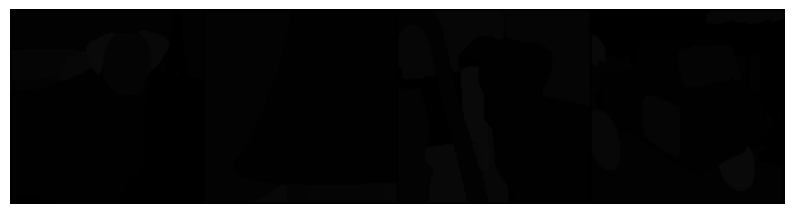

In [44]:
from torchvision.utils import make_grid

# Create a grid of images and masks
image_grid = make_grid(masks, nrow=4, normalize=False, value_range=(-1, 1))

# Display the grid
plt.figure(figsize=(10, 10))
plt.imshow(image_grid.permute(1, 2, 0).cpu(), cmap='gray')
plt.axis('off')
plt.show()


In [46]:
image_grid = mask_transform(image_grid)
image_grid.shape

torch.Size([1, 260, 1034])

In [39]:
image_grid = image_grid.permute(1, 2, 0)

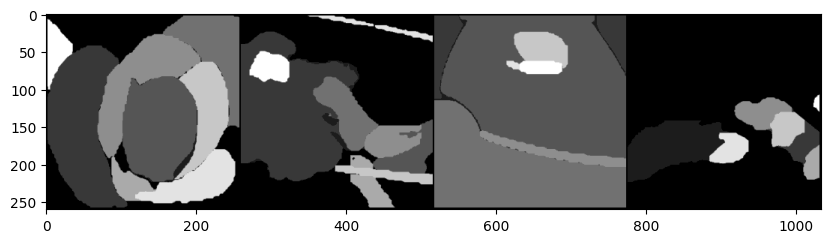

In [40]:
plt.figure(figsize=(10, 10))
plt.imshow(image_grid.cpu(), cmap='gray')

In [65]:
z.shape

torch.Size([8, 4, 32, 32])

In [66]:
z = vae.encode(masks).latent_dist.sample().mul_(0.18215)
z = torch.cat([z, z], 0)

y = torch.tensor(class_indices, device=device)
y_null = torch.tensor([100] * 4, device=device)
y = torch.cat([y, y_null], 0)
val_model_kwargs = dict(y=y, cfg_scale=4.0)


/tmp/ipykernel_2250182/2778512067.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(class_indices, device=device)


In [67]:
samples = diffusion.p_sample_loop(
    model.forward_with_cfg, z.shape, z, clip_denoised=False, model_kwargs=val_model_kwargs, progress=True, device=device
)

100%|██████████| 1000/1000 [00:02<00:00, 429.39it/s]


In [68]:
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

In [69]:
samples.shape

torch.Size([4, 3, 256, 256])

In [70]:
sample_grid = make_grid(samples, nrow=4, normalize=True, value_range=(-1, 1))


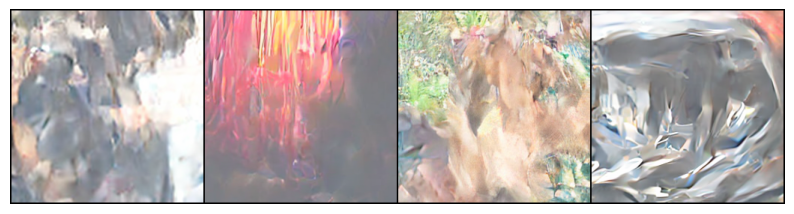

In [71]:
plt.figure(figsize=(10, 10))
plt.imshow(sample_grid.permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()

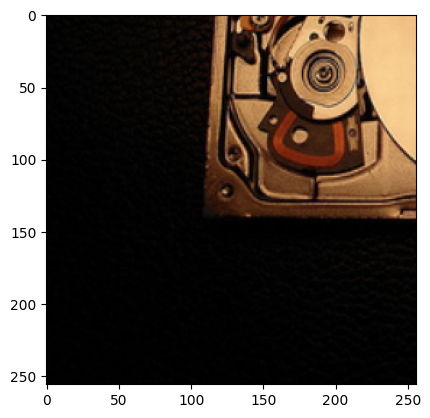

In [75]:
plt.imshow(image[0].permute(1, 2, 0).cpu().numpy())

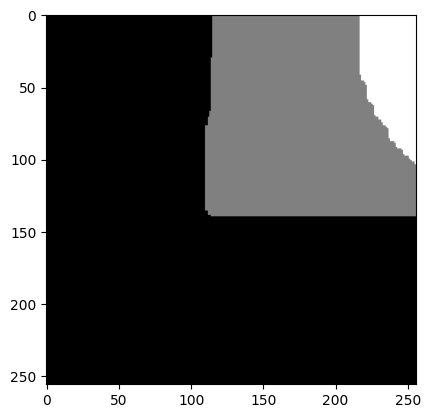

In [76]:
mask_display = mask[0].permute(1, 2, 0).cpu().numpy()
#turn into gray scale
mask_display = mask_display[:,:,0]
plt.imshow(mask_display, cmap='gray')


In [77]:
torch.tensor(mask).unique()

/tmp/ipykernel_2194782/2283926620.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(mask).unique()


tensor([0.0039, 0.0078, 0.0118], device='cuda:0')

In [78]:
z = vae.encode(mask).latent_dist.sample().mul_(0.18215)
# z = vae.encode(mask).latent_dist.sample().mul_(0.18215)

z = torch.cat([z, z], 0)
y = torch.tensor(class_index, device=device)
y_null = torch.tensor([100] * 1, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=4.0)

/tmp/ipykernel_2194782/607379006.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(class_index, device=device)


In [79]:
samples = diffusion.p_sample_loop(
        model.forward_with_cfg, z.shape, z, clip_denoised=False, model_kwargs=model_kwargs, progress=True, device=device
    )


100%|██████████| 1000/1000 [00:02<00:00, 446.88it/s]


In [80]:
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

In [81]:
save_image(samples, "sample.png", nrow=4, normalize=True, value_range=(-1, 1))

In [82]:
mask_vae = vae.encode(mask).latent_dist.sample().mul_(0.18215)
mask_vae = vae.decode(mask_vae / 0.18215).sample
mask_vae = mask_vae.squeeze(0)
mask_vae = mask_vae.detach().cpu().numpy()
mask_vae = mask_vae.transpose(1, 2, 0)
mask_vae = Image.fromarray((mask_vae * 255).astype('uint8'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


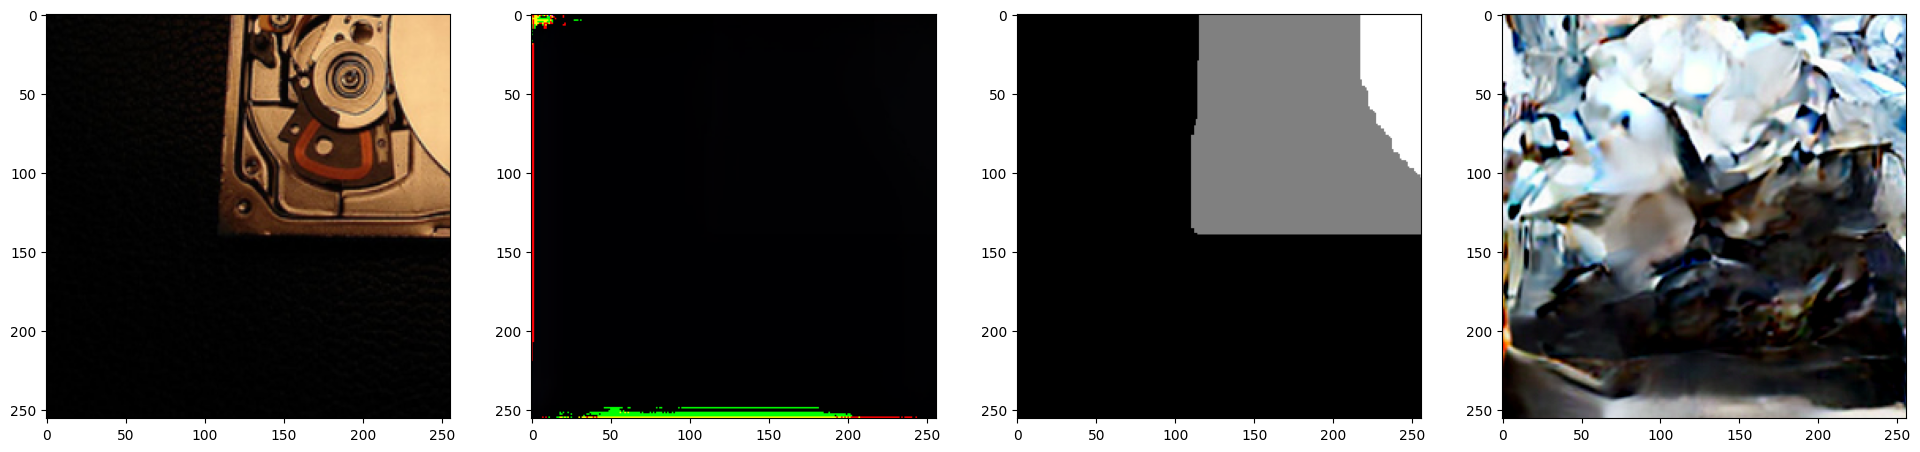

In [83]:
import matplotlib.pyplot as plt
plt.figure(figsize=(24, 8))
plt.subplot(1, 4, 1)
plt.imshow(image[0].permute(1, 2, 0).cpu().numpy())
plt.subplot(1, 4, 2)
plt.imshow(mask_vae)
plt.subplot(1, 4, 3)
plt.imshow(mask_display, cmap='gray')

plt.subplot(1, 4, 4)
plt.imshow(samples[0].permute(1, 2, 0).cpu().numpy())
plt.show()

100%|██████████| 1000/1000 [00:02<00:00, 448.03it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


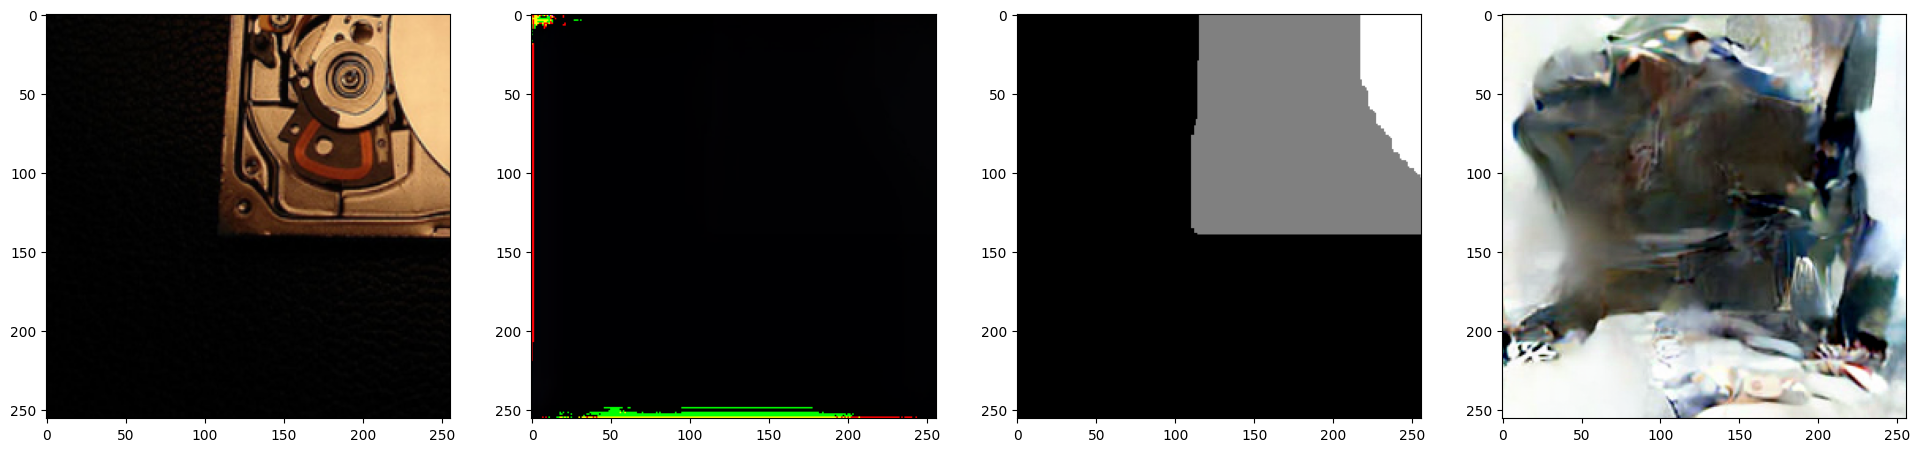

In [85]:
samples = diffusion.p_sample_loop(
        model.forward_with_cfg, z.shape, z, clip_denoised=False, model_kwargs=model_kwargs, progress=True, device=device
    )
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample
mask_vae = vae.encode(mask).latent_dist.sample().mul_(0.18215)
mask_vae = vae.decode(mask_vae / 0.18215).sample
mask_vae = mask_vae.squeeze(0)
mask_vae = mask_vae.detach().cpu().numpy()
mask_vae = mask_vae.transpose(1, 2, 0)
mask_vae = Image.fromarray((mask_vae * 255).astype('uint8'))
import matplotlib.pyplot as plt
plt.figure(figsize=(24, 8))
plt.subplot(1, 4, 1)
plt.imshow(image[0].permute(1, 2, 0).cpu().numpy())
plt.subplot(1, 4, 2)
plt.imshow(mask_vae)
plt.subplot(1, 4, 3)
plt.imshow(mask_display, cmap='gray')
plt.subplot(1, 4, 4)
plt.imshow(samples[0].permute(1, 2, 0).cpu().numpy())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


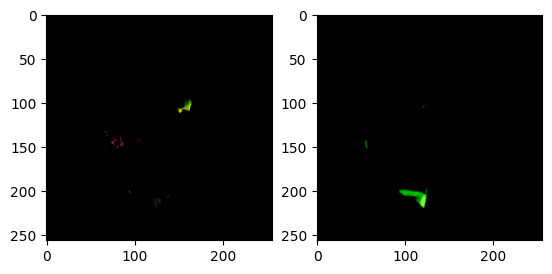

In [187]:
#simple overlap of the sample vs image and sample vs mask
import cv2
import numpy as np

overlaid = cv2.addWeighted(image[0].permute(1, 2, 0).cpu().numpy(), 1, samples[0].permute(1, 2, 0).cpu().numpy(), 1, 0)
overlaid_mask = cv2.addWeighted(mask[0].permute(1, 2, 0).cpu().numpy(), 1, samples[0].permute(1, 2, 0).cpu().numpy(), 1, 0)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(overlaid)
plt.subplot(1, 2, 2)
plt.imshow(overlaid_mask)
plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


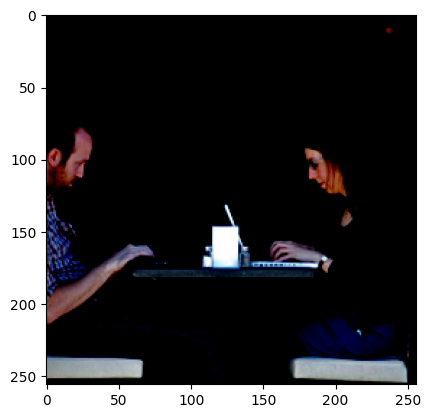

In [420]:
plt.imshow(image[0].permute(1, 2, 0).cpu().numpy())
